In [138]:
%pylab inline
import numpy as np
import pandas as pd
from scipy import stats
from scipy import optimize
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product
import datetime as dt
from calendar import monthrange

Populating the interactive namespace from numpy and matplotlib


/opt/anaconda3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['product']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
data = pd.read_csv('data_original/common.csv', parse_dates=['Date'])

#Для каждого филиала для каждого месяца
#Строим таблицу (День в месяце X количество заказов)

res = dict()
branches = data.Point.unique()
for branch in branches:
    branch_data = data[data.Point == branch]
    max_date = branch_data.Date.max()
    min_date = branch_data.Date.min()
    max_date -= dt.timedelta(days=max_date.day-1)
    min_date -= dt.timedelta(days=min_date.day-1)
    date = min_date
    while date <= max_date:
        next_date = date + dt.timedelta(days=monthrange(date.year, date.month)[1])
        part = branch_data[np.logical_and(branch_data.Date >= date,  branch_data.Date < next_date)]                      
        count = pd.DataFrame()
        count['Count'] = part.Count
        count.index = part.Date.apply(lambda x: x.day)
        count = count[pd.notnull(count.Count)]
        res[(date, branch)] = count
        date = next_date       

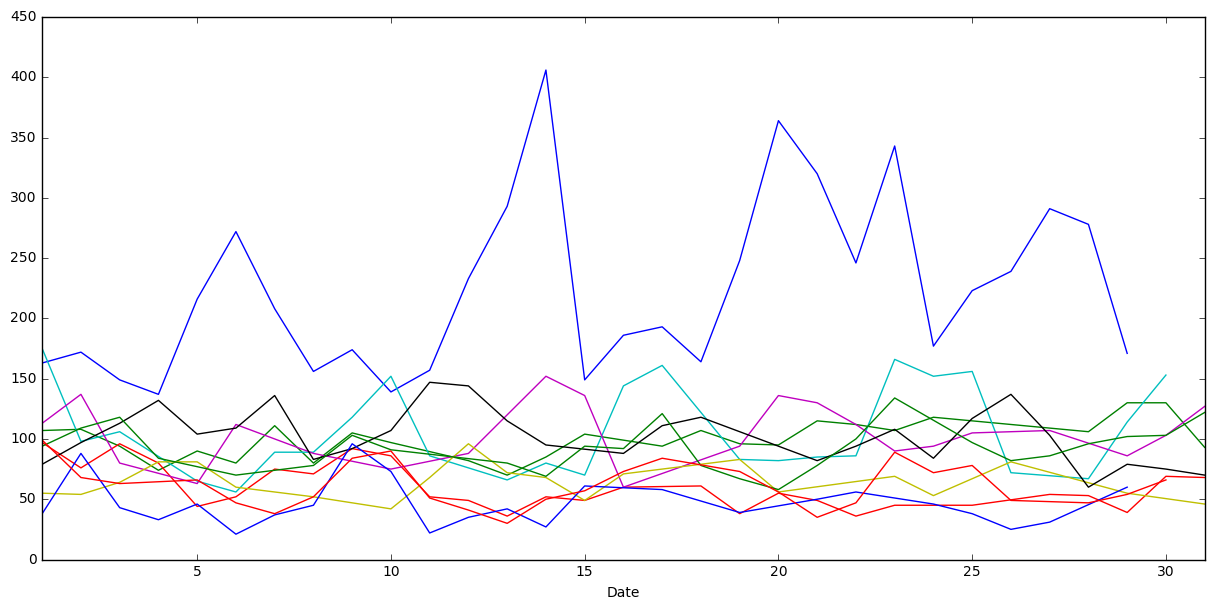

In [3]:
plt.figure(figsize(15,7))
for  val in list(res.items())[:10]:
    val[1].Count.plot()

pylab.show()

In [70]:
target = pd.read_csv('data_transform/target.csv')
data = pd.read_csv('data_original/common.csv', parse_dates=['Date'])
train_data = data[target.IsTrain == 1]

branch_train = train_data[train_data.Point == 'Сыктывкар-1']

one_day = datetime.timedelta(days=1)
sequence = list()
sequences = list()

for i in zip(branch_train.index[:-1], branch_train.index[1:]):    
    if (branch_train.loc[i[1], 'Date'] - branch_train.loc[i[0], 'Date']).days == 1: 
        sequence.append(i[0])
    else:
        if len(sequence) > 6:
            sequences.append(branch_train.loc[sequence])
        sequence = list()
len(sequences)

31

In [107]:
validate_data = data[target.IsValidation == 1]
branch_validate = validate_data[validate_data.Point == 'Сыктывкар-1']

vnt_data = data[np.logical_or(target.IsValidation == 1, target.IsTrain == 1)]
vnt_branch = vnt_data[vnt_data.Point == 'Сыктывкар-1']

validate_indexes = pd.Series(branch_validate.index)

to_predict = list()

for i in branch_validate.index:
    left = np.where(vnt_branch.index == i)
    right = left[0] + 7
    if left > 0 & right < vnt_branch.index.size:
        indexes = vnt_branch.index[left[0]:right+1]
        if (np.sum(pd.Series(indexes).isin(validate_indexes)) == 1) & ((vnt_branch.loc[indexes[-1], 'Date'] - vnt_branch.loc[indexes[0], 'Date']).days == 7):
            to_predict.append(vnt_branch.loc[indexes])
        
    

/opt/anaconda3/lib/python3.5/site-packages/pandas/indexes/base.py:1269: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  return promote(getitem(key))


In [144]:
def f(x, a, b):
    return a + b*x

In [148]:
for predict in to_predict:
    predict = predict.Count.as_matrix()
    sim1 = predict[[0, 1, 2, 4, 5, 6]]
    max_corr = 0;
    for sequence in sequences:
        sequence = sequence.Count.as_matrix()
        for i in range(len(sequence)-7):
            sim2 = sequence[[i, i+1, i+2, i+4, i+5, i+6]]
            corr = abs(np.corrcoef(sim1, sim2)[0][1])
            if max_corr < corr:
                max_corr = corr
                max_sim = sequence[range(i, i+7)]
    print (optimize.leastsq(func, x0=np.array([0.0]), args=(max_sim[[0, 1, 2, 4, 5, 6]], sim1)))
    
    

(array([-2.1232163]), 3)
(array([-1.76161646]), 3)
(array([-0.91821205]), 3)
(array([-0.86219119]), 3)
(array([-0.9916824]), 3)
(array([-0.90050151]), 2)
(array([-0.66186171]), 2)
(array([-0.54380158]), 3)
(array([-0.75740973]), 3)
(array([-1.26975539]), 3)
(array([-0.34440061]), 3)
(array([-0.32974521]), 3)
(array([-0.92541204]), 3)
(array([-1.07259417]), 2)
(array([-1.53807509]), 2)
(array([-0.94786016]), 2)
(array([-0.93631178]), 3)
(array([-0.86285906]), 3)
(array([-0.96856931]), 3)
(array([-1.49444962]), 3)
(array([-0.42387663]), 3)
(array([-1.46990001]), 2)
(array([-1.0920391]), 3)
(array([-1.494495]), 3)
(array([-0.84999615]), 2)
(array([-0.94546175]), 2)
(array([-1.20788385]), 3)
(array([-1.08785709]), 3)
